<h1> Classification des tweets - Approche simple </h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os

In [2]:
# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [3]:
# Lancement de Mlflow
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("projet_7")

<Experiment: artifact_location='mlflow-artifacts:/557530386428684495', creation_time=1713335388110, experiment_id='557530386428684495', last_update_time=1713335388110, lifecycle_stage='active', name='projet_7', tags={}>

## Cleaning dataframe
* Dataframe sans noms de colonnes
* Colonne 3 une seule valeur --> suppression
* Les classes sont équilibrées
* Certains tweets et ce qui semble être la colonne id du tweet semblent êtres dupliqués
    * Certains tweets_id sont bien dupliqués et ont les deux étiquettes --> Supression de ces tweets et de la colonne tweet_id
    * D'autres tweets sont dupliqués et n'ont pas le même label --> Suppression de ces tweets
    * D'autres tweets sont dupliqués et ont le même label --> Conservation des tweets
* Changement des labels en 0 et 1
* Transformation de la colonne date en datetime

### Vérifications des données

#### Début du cleaning

In [55]:
df_import = pd.read_csv('documents/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)

In [5]:
df_import

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


<Axes: >

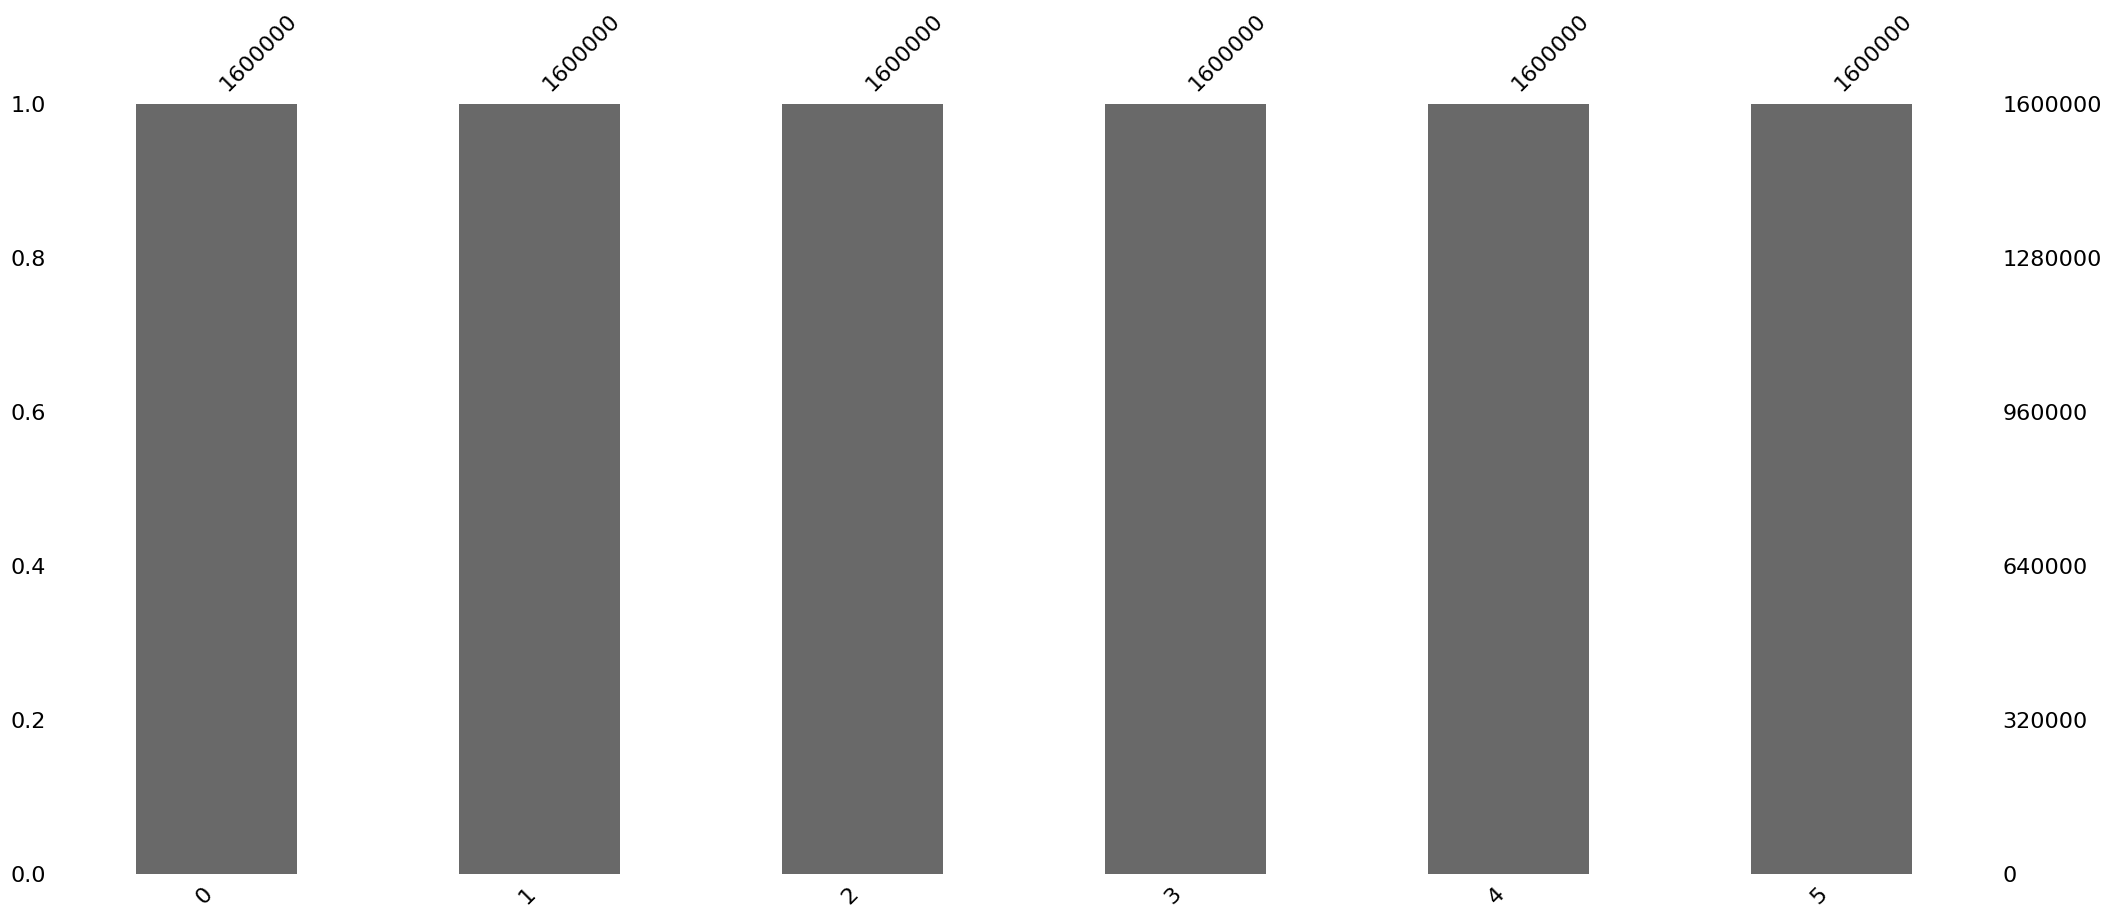

In [6]:
msno.bar(df_import)

In [7]:
# Voir le nombre de valeurs par variable

print(f'df shape : {df_import.shape}')
df_import.nunique()

df shape : (1600000, 6)


0          2
1    1598315
2     774363
3          1
4     659775
5    1581466
dtype: int64

In [57]:
df_import[0].value_counts()

0
0    800000
4    800000
Name: count, dtype: int64

In [8]:
# Retirer la colonne 3 qui n'a qu'une valeur
df_import = df_import.drop(3, axis=1)

In [9]:
# Donner un nom aux colonnes
df_import = df_import.rename(columns={0: 'label', 1: 'tweet_id', 2: 'date', 4: 'author', 5: 'tweet'})

In [10]:
# Voir s'il y a des lignes dupliquées
df_import.duplicated().any()

False

In [11]:
# Analyser les valeurs dupliquées de la colonne tweet_id
df_import_duplicated = df_import[df_import['tweet_id'].duplicated(keep=False)].sort_values('tweet_id')
print(f'df_import_duplicated shape : {df_import_duplicated.shape}')
df_import_duplicated.nunique()

df_import_duplicated shape : (3370, 5)


label          2
tweet_id    1685
date        1676
author      1601
tweet       1678
dtype: int64

#### Duplicated tweet_id

In [12]:
#  verifier que chaque valeur unique de la colonne tweet_id est bien répété deux fois et a 0 et 4 en valeur de la colonne label
check_double_label = df_import_duplicated.groupby('tweet_id')['label'].nunique()
(check_double_label == 2).all()

True

In [13]:
# Récupérer les indices des tweets à double étiquette
duplicated_indices = df_import_duplicated.index

# Supprimer ces lignes du df
df_import = df_import.drop(duplicated_indices)

In [14]:
# Suppression de la colonne qui n'a plus qu'une valeur
df_import = df_import.drop('tweet_id', axis=1)

#### Duplicated tweet

In [15]:
# Voir le nombre de valeurs par variable
print(f'df shape : {df_import.shape}')
df_import.nunique()

df shape : (1596630, 4)


label           2
date       774242
author     659502
tweet     1579794
dtype: int64

In [16]:
# Analyser les valeurs dupliquées de la colonne tweet
df_tweet_duplicated = df_import[df_import['tweet'].duplicated(keep=False)].sort_values('tweet')
grouped_tweet = df_tweet_duplicated.groupby('tweet')['label'].nunique()
(grouped_tweet == 1).all()

False

In [17]:
# Analyser les tweets identiques qui n'ont pas le même label
tweets_with_multiple_labels = grouped_tweet[grouped_tweet > 1].index
df_tweet_duplicated_different_label = df_tweet_duplicated[df_tweet_duplicated['tweet'].isin(tweets_with_multiple_labels)]
df_tweet_duplicated_different_label

,label,date,author,tweet
507399,0,Mon Jun 15 22:46:53 PDT 2009,Aryy1,I love you
1272390,4,Mon Jun 01 22:42:09 PDT 2009,thatLenakid,I love you
1030537,4,Tue May 26 22:35:11 PDT 2009,bradbury731,That is all.
730048,0,Sun Jun 21 00:52:30 PDT 2009,Jessica_Tucker,That is all.
1268996,4,Mon Jun 01 21:29:16 PDT 2009,Richard_0,goodnight
...,...,...,...,...
1299468,4,Tue Jun 02 10:43:33 PDT 2009,elainer614,working from home
645646,0,Fri Jun 19 03:26:33 PDT 2009,ashokvarda,working from home
633849,0,Thu Jun 18 20:53:18 PDT 2009,hashbrown311,working out
1264530,4,Mon Jun 01 19:54:49 PDT 2009,lauriegold11,working out


In [18]:
# Récupérer les indices des tweets à double étiquette
duplicated_indices_2 = df_tweet_duplicated_different_label.index

# Supprimer ces lignes du df
df_import = df_import.drop(duplicated_indices_2)

#### Fin du cleaning et création de df

In [19]:
# Transformation des labels
df_import['label'] = df_import['label'].replace(4, 1)

In [20]:
# Transformation des dates en datetime
df_import['date'] = pd.to_datetime(df_import['date'], format='%a %b %d %H:%M:%S PDT %Y')

In [21]:
df = df_import.copy().reset_index(drop=True)
df

,label,date,author,tweet
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...
1593125,1,2009-06-16 08:40:49,AmandaMarie1028,Just woke up. Having no school is the best fee...
1593126,1,2009-06-16 08:40:49,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1593127,1,2009-06-16 08:40:49,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1593128,1,2009-06-16 08:40:49,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [22]:
df.to_csv('data/tweets_clean.csv', index=False)

### Tokenization des tweets

#### Fonctions de tokenization

In [23]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
def tokenizer_with_hash_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def tokenizer_no_hash_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [26]:
# Fonction de préparation du texte pour le bag of words
def transform_bow_no_hash_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_no_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec hashtags
def transform_bow_with_hash_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization et hashtags
def transform_bow_with_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

#### Transformation des tweets 

In [57]:
df_tok = pd.read_csv('data/tweets_clean.csv')

In [58]:
df_tok['hash'] = df_tok['tweet'].apply(lambda x : transform_bow_with_hash_fct(x))
df_tok['no_hash'] = df_tok['tweet'].apply(lambda x : transform_bow_no_hash_fct(x))
df_tok['hash_lem'] = df_tok['tweet'].apply(lambda x : transform_bow_with_hash_lem_fct(x))
df_tok['no_hash_lem'] = df_tok['tweet'].apply(lambda x : transform_bow_no_hash_lem_fct(x))
df_tok['dl'] = df_tok['tweet'].apply(lambda x : transform_dl_fct(x))

In [69]:
# Retirer les lignes qui contiennent des nan après transformation
df_tok = df_tok[df_tok['hash'].isnull() == False]
df_tok = df_tok[df_tok['hash'] != '']
df_tok = df_tok.reset_index(drop=True)

In [71]:
df_tok.to_csv('data/tweets_tokenized.csv')

# Prédictions simples

In [63]:
df = pd.read_csv('data/tweets_tokenized.csv')

## Tf idf

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

### test avec différentes tokenization

In [8]:
def regression_tfidf(df, column) :
    X = df[column]
    y = df['label']

    split_params = {
        'test_size': 0.2,
        'random_state': 42,
        'stratify': y
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, **split_params)


    vec_params = {
        'stop_words': 'english',
        'max_df': 0.95,
        'min_df': 1
    }
    tfidf = TfidfVectorizer(**vec_params)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)


    model_params ={
        'max_iter': 1000,
        'solver': 'saga',
        'penalty': 'l2'
    }
    lr = LogisticRegression(**model_params)
    lr.fit(X_train_tfidf, y_train)
    y_pred = lr.predict(X_test_tfidf)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [75]:
columns = ['hash', 'no_hash', 'hash_lem', 'no_hash_lem']
for column in columns :
    print(f'Formatage : {column}')
    print()
    regression_tfidf(df, column)
    print()
    print('--------------------------------------------')
    print()

Formatage : hash

[[120319  38909]
 [ 31834 127490]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159228
           1       0.77      0.80      0.78    159324

    accuracy                           0.78    318552
   macro avg       0.78      0.78      0.78    318552
weighted avg       0.78      0.78      0.78    318552


--------------------------------------------

Formatage : no_hash

[[120319  38909]
 [ 31832 127492]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159228
           1       0.77      0.80      0.78    159324

    accuracy                           0.78    318552
   macro avg       0.78      0.78      0.78    318552
weighted avg       0.78      0.78      0.78    318552


--------------------------------------------

Formatage : hash_lem

[[120223  39005]
 [ 32079 127245]]
              precision    recall  f1-score   support

           0       0.79      0.

### Prédiction avec la tokenization choisie

In [65]:
X = df['hash']
y = df['label']

# Séparer les données en ensemble de train et de test
split_params = {
    'test_size': 0.2,
    'random_state': 42,
    'stratify': y
}
X_train, X_test, y_train, y_test = train_test_split(X, y, **split_params)

# Vectoriser les tweets
vec_params = {
    'stop_words': 'english',
    'max_df': 0.95,
    'min_df': 1
}
tfidf = TfidfVectorizer(**vec_params)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Créer et entrainer le modèle
model_params ={
    'max_iter': 1000,
    'solver': 'saga',
    'penalty': 'l2'
}
lr = LogisticRegression(**model_params)
lr.fit(X_train_tfidf, y_train)

# Prédire les labels et enregistrer le temps de prédiction
start_time = time.time()
y_pred = lr.predict(X_test_tfidf)
prediction_time = time.time() - start_time

# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

# Afficher les résultats
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

[[120319  38909]
 [ 31834 127490]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159228
           1       0.77      0.80      0.78    159324

    accuracy                           0.78    318552
   macro avg       0.78      0.78      0.78    318552
weighted avg       0.78      0.78      0.78    318552



In [66]:
with mlflow.start_run(run_name="TfIdf with logistic regression"):
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Infer the model signature
    signature = infer_signature(X_train_tfidf, lr.predict(X_train_tfidf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="Logistic_Regression_TfIdf",
        signature=signature,
        input_example=X_train_tfidf,
        registered_model_name="Logistic_Regression_TfIdf",
    )

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic_Regression_TfIdf' already exists. Creating a new version of this model...
2024/04/17 13:06:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic_Regression_TfIdf, version 4
Created version '4' of model 'Logistic_Regression_TfIdf'.


## Word2Vec

### Méthode 1 : simple embedding

In [46]:
def regression_word2vec(df, column):
    X = df[column].apply(lambda x: x.split())  # split documents into words
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # reset indices
    X_train_lem = X_train_lem.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # train Word2Vec model
    w2v = Word2Vec(X_train, min_count=1)
    
    # transform documents to vectors
    X_train_w2v = X_train.apply(lambda x: np.mean([w2v.wv[word] for word in x], axis=0))
    X_test_w2v = X_test.apply(lambda x: np.mean([w2v.wv[word] for word in x if word in w2v.wv] or [np.zeros(w2v.vector_size)], axis=0))
    # filter out None vectors
    train_indices = [i for i, v in enumerate(X_train_w2v) if v is not None]
    test_indices = [i for i, v in enumerate(X_test_w2v) if v is not None]
    X_train_w2v = [X_train_w2v[i] for i in train_indices]
    X_test_w2v = [X_test_w2v[i] for i in test_indices]
    y_train = y_train.iloc[train_indices]
    y_test = y_test.iloc[test_indices]


    lr = LogisticRegression(max_iter=1000, solver='saga', penalty='l2')
    lr.fit(list(X_train_w2v), y_train)
    y_pred = lr.predict(list(X_test_w2v))

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [2]:
columns = ['hash', 'no_hash', 'hash_lem', 'no_hash_lem']
for column in columns :
    print(f'Formatage : {column}')
    print()
    regression_word2vec(df, column)
    print()
    print('--------------------------------------------')
    print()

Formatage : hash



NameError: name 'regression_word2vec' is not defined

### Méthode 2 : Embedding plus complexe

In [90]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

2024-04-17 07:59:53.052382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 07:59:53.124810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'triu' from 'scipy.linalg' (/usr/local/lib/python3.11/dist-packages/scipy/linalg/__init__.py)

In [53]:
import time

def make_W2V_embeddings(df, col):
    start_time = time.time()
    
    w2v_size=300
    w2v_window=5
    w2v_min_count=1
    w2v_epochs=100
    maxlen = df[col].apply(lambda x : len(x)).max()
    sentences = df[col].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

    # Création et entraînement du modèle Word2Vec
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=os.cpu_count())

    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print('Modèle Word2Vec entraîné. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Préparation des sentences (tokenization)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                        maxlen=maxlen,
                                                        padding='post') 
                                                    
    num_words = len(tokenizer.word_index) + 1
    print('Sentences tokenizées. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création de la matrice d'embedding
    w2v_size = 300
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
        
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    word_rate = np.round(j/i,4)
    print('Matrice d\'embedding créée. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création du modèle
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                            output_dim=w2v_size,)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)
    print('Modèle créé. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))

    # Création des embeddings
    embeddings = embed_model.predict(x_sentences)
    print('Embeddings créés. Temps écoulé: {:.2f} secondes'.format(time.time() - start_time))
    
    return embeddings

In [54]:
def regression_word2vec(df, column):

    embeddings = make_W2V_embeddings(df, column)

    # Train logistic regression
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(max_iter=1000, solver='saga', penalty='l2')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [55]:
regression_word2vec(df, 'hash')

Modèle Word2Vec entraîné. Temps écoulé: 617.67 secondes
Sentences tokenizées. Temps écoulé: 631.05 secondes
Matrice d'embedding créée. Temps écoulé: 5898.74 secondes


2024-04-15 15:05:43.450227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 15:05:43.668710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 15:05:43.669372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 15:05:43.753586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 15:05:43.753772: I external/local_xla/xla/stream_executor

Modèle créé. Temps écoulé: 5910.06 secondes


I0000 00:00:1713193556.446088   69555 service.cc:145] XLA service 0x7f4b28003250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713193556.446951   69555 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-04-15 15:05:56.932404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   85/49774 ━━━━━━━━━━━━━━━━━━━━ 1:30 2ms/step

I0000 00:00:1713193557.255935   69555 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49774/49774 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step
Embeddings créés. Temps écoulé: 5998.54 secondes
[[108973  49690]
 [ 72315  87574]]
              precision    recall  f1-score   support

           0       0.60      0.69      0.64    158663
           1       0.64      0.55      0.59    159889

    accuracy                           0.62    318552
   macro avg       0.62      0.62      0.62    318552
weighted avg       0.62      0.62      0.62    318552



# Prédictions avancées

In [51]:
from gensim.models import Word2Vec, FastText
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, RMSprop


In [4]:
df = pd.read_csv('data/tweets_tokenized.csv')

### Sélection des données

In [5]:
X_full = df['dl']
y_full = df['label']

_, X, _, y = train_test_split(X_full, y_full, test_size=0.1, stratify=y_full, random_state=42)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [10]:
X_full_lem = df['hash_lem']

_, X_lem, _, y_lem = train_test_split(X_full_lem, y_full, test_size=0.1, stratify=y_full, random_state=42)

# Split the data into training, validation, and test sets
X_train_lem, X_temp_lem, y_train_lem, y_temp_lem = train_test_split(X_lem, y_lem, test_size=0.4, stratify=y_lem, random_state=42)
X_val_lem, X_test_lem, y_val_lem, y_test_lem = train_test_split(X_temp_lem, y_temp_lem, test_size=0.5, stratify=y_temp_lem, random_state=42)

### Fonctions de visualisation

In [15]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [16]:
# Afficher l'évolution des performances lors de l'entrainement
def visualize_history(history):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(history.history['loss'], label='Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Modèle Kera simple avec embedding Word2Vec

### Sans lemmatization

In [23]:
# Préparation de l'embedding

# Entrainer le modèle d'embedding sur les données d'entrainement
word2vec = Word2Vec(X_train, min_count=1)

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_w2v = tokenizer.texts_to_sequences(X_train)
X_val_w2v = tokenizer.texts_to_sequences(X_val)
X_test_w2v = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_w2v)
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_seq)
X_val_w2v = pad_sequences(X_val_w2v, maxlen=max_seq)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_seq)

# Préparation de la matrice d'embedding
embedding_dim = word2vec.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

In [49]:
# Définir le modèle

model_w2v = Sequential()

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

# Ajouter les couches
model_w2v.add(embedding_layer)
model_w2v.add(Flatten())
model_w2v.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_w2v.add(BatchNormalization())
model_w2v.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# Entrainer le modèle

# Création du callback
model_save_path_w2v = "./data/model_best_weights_w2v.keras"
checkpoint = ModelCheckpoint(model_save_path_w2v, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_w2v = model_w2v.fit(
    X_train_w2v, 
    y_train, 
    validation_data=(X_val_w2v, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


2987/2987 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6003 - loss: 2.0157 - val_accuracy: 0.7551 - val_loss: 0.7980
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7950 - loss: 0.7626 - val_accuracy: 0.7745 - val_loss: 0.7947
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8375 - loss: 0.7093 - val_accuracy: 0.7639 - val_loss: 0.8464
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8824 - loss: 0.6482 - val_accuracy: 0.7534 - val_loss: 0.9167
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9190 - loss: 0.5844 - val_accuracy: 0.7424 - val_loss: 0.9971
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9416 - loss: 0.5336 - val_accuracy: 0.7415 - val_loss: 1.0786
Epoch 7/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9537 - loss: 0.5025 - val_accuracy: 0.7282 - val_loss: 1.1913


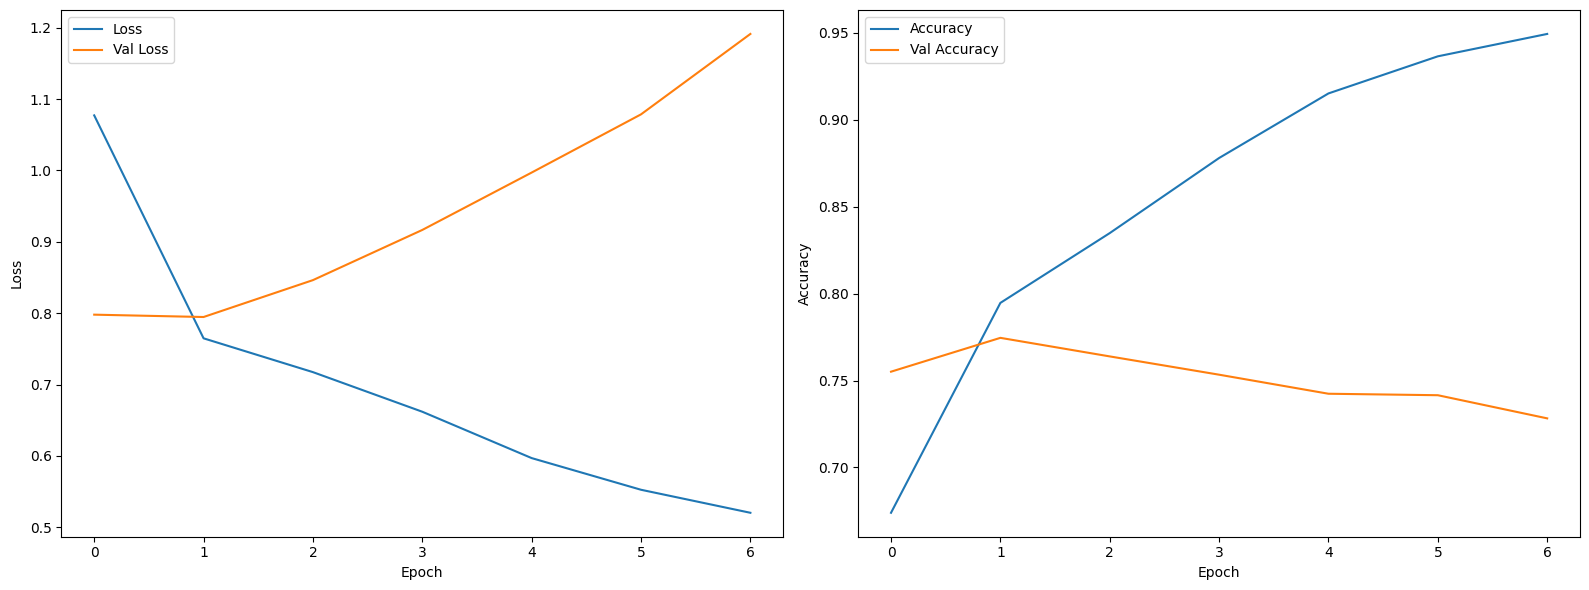

In [51]:
visualize_history(history_w2v)

In [52]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_w2v.evaluate(X_val_w2v, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_w2v.evaluate(X_test_w2v, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7282
Validation loss:  1.1913
Test Accuracy       :  0.7325
Test loss:  1.1826


In [69]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_w2v.load_weights(model_save_path_w2v)

loss, accuracy = model_w2v.evaluate(X_val_w2v, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_w2v.evaluate(X_test_w2v, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7745
Validation loss:  0.7947
Test Accuracy       :  0.7750
Test loss:  0.7897


In [72]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Simple Keras model with Word2Vec W2V embedding"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_w2v.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_w2v, model_w2v.predict(X_train_w2v))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_w2v,
        artifact_path="Keras_Word2Vec",
        signature=signature,
        registered_model_name="Keras_Word2Vec",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Successfully registered model 'Keras_Word2Vec'.
2024/04/17 13:10:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Word2Vec, version 1
Created version '1' of model 'Keras_Word2Vec'.


### Avec lemmatization

In [11]:
# Préparation de l'embedding

# Entrainer le modèle d'embedding sur les données d'entrainement
word2vec = Word2Vec(X_train_lem, min_count=1)

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lem)
X_train_lem_w2v = tokenizer.texts_to_sequences(X_train_lem)
X_val_lem_w2v = tokenizer.texts_to_sequences(X_val_lem)
X_test_lem_w2v = tokenizer.texts_to_sequences(X_test_lem)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_lem_w2v)
X_train_lem_w2v = pad_sequences(X_train_lem_w2v, maxlen=max_seq)
X_val_lem_w2v = pad_sequences(X_val_lem_w2v, maxlen=max_seq)
X_test_lem_w2v = pad_sequences(X_test_lem_w2v, maxlen=max_seq)

# Préparation de la matrice d'embedding
embedding_dim = word2vec.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

In [12]:
# Définir le modèle

model_w2v_lem = Sequential()

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

# Ajouter les couches
model_w2v_lem.add(embedding_layer)
model_w2v_lem.add(Flatten())
model_w2v_lem.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_w2v_lem.add(BatchNormalization())
model_w2v_lem.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_w2v_lem.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-04-18 06:14:14.261018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 06:14:14.322273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 06:14:14.322312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 06:14:14.325551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 06:14:14.325590: I external/local_xla/xla/stream_executor

In [13]:
# Entrainer le modèle

# Création du callback
model_save_path_w2v = "./data/model_best_weights_w2v_lem.keras"
checkpoint = ModelCheckpoint(model_save_path_w2v, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_w2v_lem = model_w2v_lem.fit(
    X_train_lem_w2v, 
    y_train_lem, 
    validation_data=(X_val_lem_w2v, y_val_lem), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


I0000 00:00:1713420924.922905   12466 service.cc:145] XLA service 0x7fdcd40199b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713420924.922941   12466 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-04-18 06:15:24.964652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-18 06:15:25.135664: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   5/2987 ━━━━━━━━━━━━━━━━━━━━ 1:33 31ms/step - accuracy: 0.5534 - loss: 22.0739

I0000 00:00:1713420925.770904   12466 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2987/2987 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6988 - loss: 1.5779 - val_accuracy: 0.7450 - val_loss: 0.7122
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8169 - loss: 0.6420 - val_accuracy: 0.7459 - val_loss: 0.7552
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8730 - loss: 0.5554 - val_accuracy: 0.7406 - val_loss: 0.8048
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9160 - loss: 0.4598 - val_accuracy: 0.7127 - val_loss: 0.9080
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9369 - loss: 0.4055 - val_accuracy: 0.7246 - val_loss: 0.9558
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9464 - loss: 0.3739 - val_accuracy: 0.7158 - val_loss: 1.0527


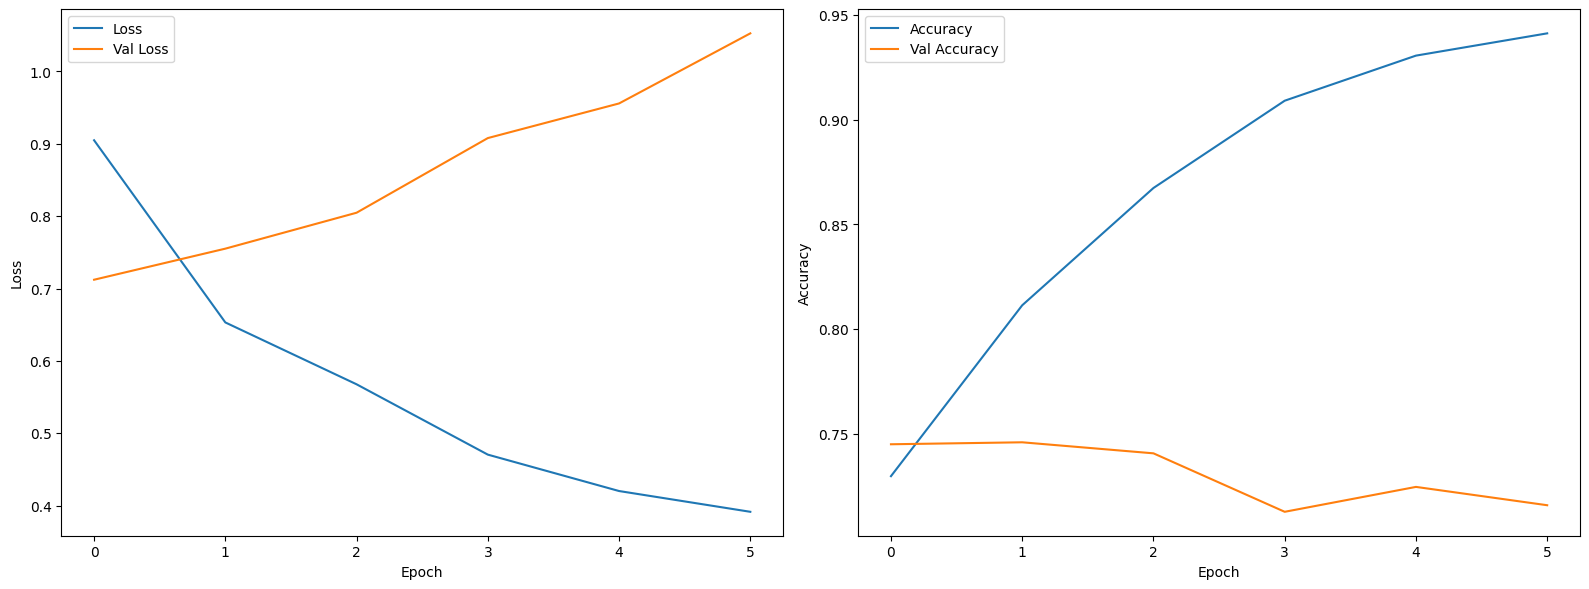

In [17]:
visualize_history(history_w2v_lem)

In [18]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_w2v_lem.evaluate(X_val_lem_w2v, y_val_lem, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_w2v_lem.evaluate(X_test_lem_w2v, y_test_lem, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7158
Validation loss:  1.0527
Test Accuracy       :  0.7147
Test loss:  1.0453


In [20]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_w2v_lem.load_weights(model_save_path_w2v)

loss, accuracy = model_w2v_lem.evaluate(X_val_lem_w2v, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_w2v_lem.evaluate(X_test_lem_w2v, y_test_lem, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7450
Validation loss:  0.7122
Test Accuracy       :  0.7526
Test loss:  0.7056


In [22]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Simple Keras model with Word2Vec W2V embedding + Lemmatization"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_w2v_lem.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_lem_w2v, model_w2v_lem.predict(X_train_lem_w2v))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_w2v_lem,
        artifact_path="Keras_Word2Vec_lem",
        signature=signature,
        registered_model_name="Keras_Word2Vec_lem",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Keras_Word2Vec_lem'.
2024/04/18 06:20:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Word2Vec_lem, version 1
Created version '1' of model 'Keras_Word2Vec_lem'.


### Avec couche lstm

In [ ]:
# Préparation de l'embedding

# Entrainer le modèle d'embedding sur les données d'entrainement
word2vec = Word2Vec(X_train, min_count=1)

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_w2v = tokenizer.texts_to_sequences(X_train)
X_val_w2v = tokenizer.texts_to_sequences(X_val)
X_test_w2v = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_w2v)
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_seq)
X_val_w2v = pad_sequences(X_val_w2v, maxlen=max_seq)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_seq)

# Préparation de la matrice d'embedding
embedding_dim = word2vec.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]

In [26]:
model_w2v_lstm = Sequential()

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

# Ajouter les couches
model_w2v_lstm.add(embedding_layer)
model_w2v_lstm.add(LSTM(32))
model_w2v_lstm.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_w2v_lstm.add(BatchNormalization())
model_w2v_lstm.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_w2v_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Entrainer le modèle

# Création du callback
model_save_path_w2v_lstm = "./data/model_best_weights_w2v_lstm.keras"
checkpoint = ModelCheckpoint(model_save_path_w2v_lstm, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_w2v_lstm = model_w2v_lstm.fit(
    X_train_w2v, 
    y_train, 
    validation_data=(X_val_w2v, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


2987/2987 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.7271 - loss: 0.8776 - val_accuracy: 0.7892 - val_loss: 0.4587
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8617 - loss: 0.3356 - val_accuracy: 0.7717 - val_loss: 0.5096
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9281 - loss: 0.2009 - val_accuracy: 0.7589 - val_loss: 0.6534
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9514 - loss: 0.1454 - val_accuracy: 0.7684 - val_loss: 0.6820
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9648 - loss: 0.1109 - val_accuracy: 0.7632 - val_loss: 0.7757
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9716 - loss: 0.0918 - val_accuracy: 0.7535 - val_loss: 0.8806


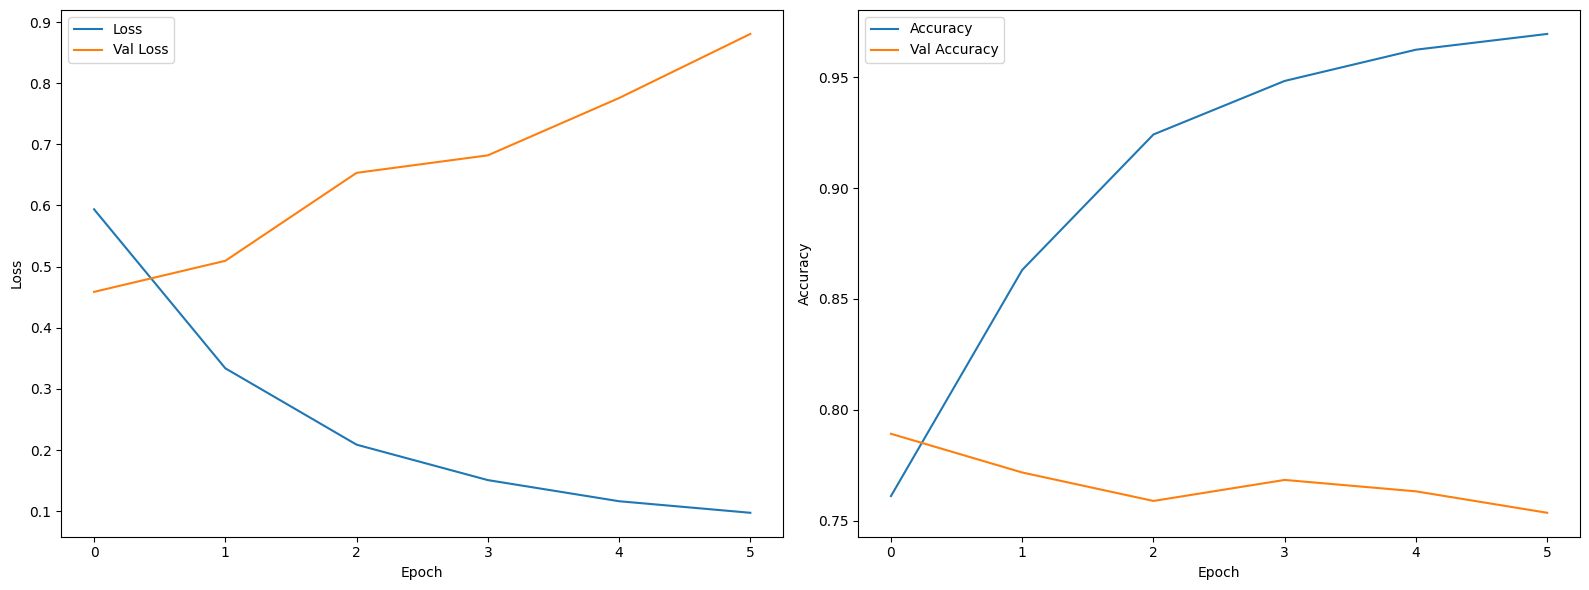

In [29]:
visualize_history(history_w2v_lstm)

In [30]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_w2v_lstm.evaluate(X_val_w2v, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_w2v_lstm.evaluate(X_test_w2v, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7535
Validation loss:  0.8806
Test Accuracy       :  0.7568
Test loss:  0.8701


In [31]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_w2v_lstm.load_weights(model_save_path_w2v_lstm)

loss, accuracy = model_w2v_lstm.evaluate(X_val_w2v, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_w2v_lstm.evaluate(X_test_w2v, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7892
Validation loss:  0.4587
Test Accuracy       :  0.7912
Test loss:  0.4540


In [32]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Simple Keras model with LSTM layer and W2V embedding"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_w2v_lstm.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_w2v, model_w2v_lstm.predict(X_train_w2v))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_w2v_lstm,
        artifact_path="Keras_Word2Vec_lstm",
        signature=signature,
        registered_model_name="Keras_Word2Vec_lstm",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Successfully registered model 'Keras_Word2Vec_lstm'.
2024/04/18 06:39:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Word2Vec_lstm, version 1
Created version '1' of model 'Keras_Word2Vec_lstm'.


## Modèle kera lstm et embedding FastText

### Premier test

In [53]:
# Préparation de l'embedding

# Entrainer le modèle d'embedding sur les données d'entrainement
fasttext_model = FastText(X_train, min_count=1)

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_ft = tokenizer.texts_to_sequences(X_train)
X_val_ft = tokenizer.texts_to_sequences(X_val)
X_test_ft = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_ft)
X_train_ft = pad_sequences(X_train_ft, maxlen=max_seq)
X_val_ft = pad_sequences(X_val_ft, maxlen=max_seq)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_seq)

# Préparation de la matrice d'embedding
embedding_dim = fasttext_model.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

In [54]:
model_ft = Sequential()

# Ajouter les couches
model_ft.add(embedding_layer)
model_ft.add(LSTM(32))
model_ft.add(Dropout(0.5))
model_ft.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_ft.add(Dropout(0.5))
model_ft.add(BatchNormalization())
model_ft.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
# Entrainer le modèle

# Création du callback
model_save_path_ft = "./data/model_best_weights_ft.keras"
checkpoint = ModelCheckpoint(model_save_path_ft, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_ft = model_ft.fit(
    X_train_ft, 
    y_train, 
    validation_data=(X_val_ft, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


2987/2987 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.6852 - loss: 0.9785 - val_accuracy: 0.7851 - val_loss: 0.4860
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8383 - loss: 0.4175 - val_accuracy: 0.7682 - val_loss: 0.5676
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.8986 - loss: 0.2994 - val_accuracy: 0.7649 - val_loss: 0.5900
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9252 - loss: 0.2382 - val_accuracy: 0.7566 - val_loss: 0.7205
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9401 - loss: 0.1993 - val_accuracy: 0.7613 - val_loss: 0.7845
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9502 - loss: 0.1736 - val_accuracy: 0.7594 - val_loss: 0.8182


In [48]:
# Imprimer les résultats
'''
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    print(f"Train accuracy: {history_ft.history['accuracy'][epoch]}")
    print(f"Validation accuracy: {history_ft.history['val_accuracy'][epoch]}")
    print(f"Train loss: {history_ft.history['loss'][epoch]}")
    print(f"Validation loss: {history_ft.history['val_loss'][epoch]}")
    print("-"*30)
'''

Epoch: 1
Train accuracy: 0.7359702587127686
Validation accuracy: 0.7850886583328247
Train loss: 0.6678287982940674
Validation loss: 0.4859887659549713
------------------------------
Epoch: 2
Train accuracy: 0.83824622631073
Validation accuracy: 0.7681996822357178
Train loss: 0.4145073890686035
Validation loss: 0.5676175951957703
------------------------------
Epoch: 3
Train accuracy: 0.8941558003425598
Validation accuracy: 0.7649348378181458
Train loss: 0.30717185139656067
Validation loss: 0.5900370478630066
------------------------------
Epoch: 4
Train accuracy: 0.9218123555183411
Validation accuracy: 0.7565531134605408
Train loss: 0.2462460845708847
Validation loss: 0.720451831817627
------------------------------
Epoch: 5
Train accuracy: 0.9362214207649231
Validation accuracy: 0.7613247632980347
Train loss: 0.20775216817855835
Validation loss: 0.784461498260498
------------------------------
Epoch: 6
Train accuracy: 0.9462355375289917
Validation accuracy: 0.7593784332275391
Train lo

IndexError: list index out of range

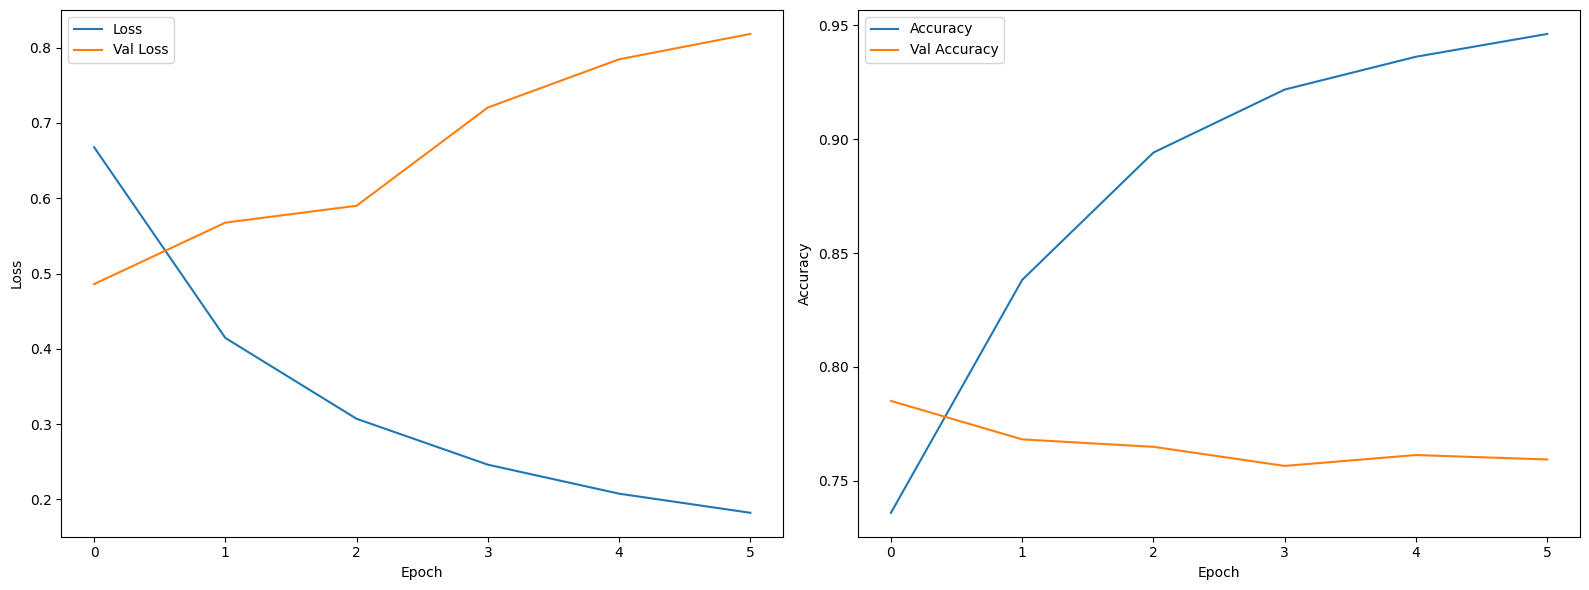

In [49]:
visualize_history(history_ft)

In [38]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_ft.evaluate(X_val_ft, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_ft.evaluate(X_test_ft, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7601
Validation loss:  0.8431
Test Accuracy       :  0.7665
Test loss:  0.8164


In [40]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_ft.load_weights(model_save_path_ft)

loss, accuracy = model_ft.evaluate(X_val_ft, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_ft.evaluate(X_test_ft, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7899
Validation loss:  0.4568
Test Accuracy       :  0.7916
Test loss:  0.4528


In [41]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Simple Keras model with LSTM layer and FastText embedding"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_ft.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_ft, model_ft.predict(X_train_ft))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_ft,
        artifact_path="Keras_FastText_lstm",
        signature=signature,
        registered_model_name="Keras_FastText_lstm",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Successfully registered model 'Keras_FastText_lstm'.
2024/04/18 06:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_FastText_lstm, version 1
Created version '1' of model 'Keras_FastText_lstm'.


### Optimisation optuna

#### Study

In [55]:
# Préparation de l'embedding

# Entrainer le modèle d'embedding sur les données d'entrainement
fasttext_model = FastText(X_train, min_count=1)

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_ft = tokenizer.texts_to_sequences(X_train)
X_val_ft = tokenizer.texts_to_sequences(X_val)
X_test_ft = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_ft)
X_train_ft = pad_sequences(X_train_ft, maxlen=max_seq)
X_val_ft = pad_sequences(X_val_ft, maxlen=max_seq)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_seq)

# Préparation de la matrice d'embedding
embedding_dim = fasttext_model.wv.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

In [66]:
import optuna

def objective(trial):
    
    print()
    print('------------------------------------------------------------------------------')
    print(f"Progress: {trial.number + 1}/{trial_number}")
    print('------------------------------------------------------------------------------')
    print()

    # Définir les hyperparamètres à optimiser
    lstm_units = trial.suggest_int('lstm_units', 8, 64)
    dense_units = trial.suggest_int('dense_units', 8, 64)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model_ft = Sequential()
    model_ft.add(embedding_layer)
    model_ft.add(LSTM(lstm_units))
    model_ft.add(Dropout(dropout_rate))
    model_ft.add(Dense(dense_units, activation=activation, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model_ft.add(Dropout(dropout_rate))
    model_ft.add(BatchNormalization())
    model_ft.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)

    model_ft.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Création du callback
    model_save_path = "./data/model_best_weights_optuna.keras"
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
    callbacks_list = [checkpoint, es]

    # Fit du modèle
    model_ft.fit(X_train_ft, y_train, validation_data=(X_val_ft, y_val), batch_size=32, epochs=20, callbacks=callbacks_list, verbose=0)

    model_ft.load_weights(model_save_path)
    val_loss = model_ft.evaluate(X_val_ft, y_val, verbose=0)[0]
    return val_loss

In [67]:
# Effacer l'étude de la base de données si erreur
# optuna.delete_study(study_name="projet-7_lstm_model", storage='sqlite:///study.db')

In [68]:
# Exécution de l'optimisation avec Optuna
trial_number = 50
pruner = optuna.pruners.PercentilePruner(
    percentile=40, 
    n_startup_trials=5, 
    n_warmup_steps=3
)

study = optuna.create_study(direction='minimize', pruner=pruner, sampler=optuna.samplers.TPESampler(), storage='sqlite:///study.db', study_name="projet-7_lstm_model")

study.optimize(objective, n_trials=trial_number)

[I 2024-04-18 07:34:30,974] A new study created in RDB with name: projet-7_lstm_model
/tmp/ipykernel_734/98002110.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.7)
/tmp/ipykernel_734/98002110.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)



------------------------------------------------------------------------------
Progress: 1/50
------------------------------------------------------------------------------



[I 2024-04-18 07:45:21,893] Trial 0 finished with value: 0.47589653730392456 and parameters: {'lstm_units': 45, 'dense_units': 56, 'dropout_rate': 0.5592946939650149, 'learning_rate': 4.34697201010499e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 2/50
------------------------------------------------------------------------------



[I 2024-04-18 07:56:35,077] Trial 1 finished with value: 0.48116743564605713 and parameters: {'lstm_units': 29, 'dense_units': 19, 'dropout_rate': 0.24742292002581137, 'learning_rate': 1.4932736347991779e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 3/50
------------------------------------------------------------------------------



[I 2024-04-18 08:00:14,111] Trial 2 finished with value: 0.5411349534988403 and parameters: {'lstm_units': 15, 'dense_units': 41, 'dropout_rate': 0.3747651480591555, 'learning_rate': 0.007041368079908117, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 4/50
------------------------------------------------------------------------------



[I 2024-04-18 08:04:14,532] Trial 3 finished with value: 0.6649969816207886 and parameters: {'lstm_units': 42, 'dense_units': 60, 'dropout_rate': 0.3699476864455108, 'learning_rate': 0.00637265643990249, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 5/50
------------------------------------------------------------------------------



[I 2024-04-18 08:09:16,108] Trial 4 finished with value: 0.5151749849319458 and parameters: {'lstm_units': 53, 'dense_units': 53, 'dropout_rate': 0.3476977045483717, 'learning_rate': 8.164009136284678e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 6/50
------------------------------------------------------------------------------



[I 2024-04-18 08:17:20,800] Trial 5 finished with value: 0.621676504611969 and parameters: {'lstm_units': 60, 'dense_units': 19, 'dropout_rate': 0.12495059935535008, 'learning_rate': 0.0012587857155906524, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 7/50
------------------------------------------------------------------------------



[I 2024-04-18 08:26:18,887] Trial 6 finished with value: 0.5862017869949341 and parameters: {'lstm_units': 64, 'dense_units': 42, 'dropout_rate': 0.6311863064494633, 'learning_rate': 0.0001565133837079086, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 8/50
------------------------------------------------------------------------------



[I 2024-04-18 08:34:18,566] Trial 7 finished with value: 0.574613094329834 and parameters: {'lstm_units': 61, 'dense_units': 46, 'dropout_rate': 0.4384140098892274, 'learning_rate': 2.9797586205911635e-05, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 9/50
------------------------------------------------------------------------------



[I 2024-04-18 08:42:10,924] Trial 8 finished with value: 0.5604071021080017 and parameters: {'lstm_units': 41, 'dense_units': 58, 'dropout_rate': 0.6607854519153883, 'learning_rate': 2.913757460605832e-05, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 10/50
------------------------------------------------------------------------------



[I 2024-04-18 08:50:34,207] Trial 9 finished with value: 0.5317298173904419 and parameters: {'lstm_units': 8, 'dense_units': 43, 'dropout_rate': 0.571664902219248, 'learning_rate': 2.4741241938774898e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 11/50
------------------------------------------------------------------------------



[I 2024-04-18 08:55:08,138] Trial 10 finished with value: 0.5850993990898132 and parameters: {'lstm_units': 30, 'dense_units': 26, 'dropout_rate': 0.5105259896276337, 'learning_rate': 0.0007563732941163151, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 12/50
------------------------------------------------------------------------------



[I 2024-04-18 09:07:35,492] Trial 11 finished with value: 0.6441192030906677 and parameters: {'lstm_units': 29, 'dense_units': 13, 'dropout_rate': 0.21476527320515632, 'learning_rate': 1.2918422939129425e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 13/50
------------------------------------------------------------------------------



[I 2024-04-18 09:20:03,945] Trial 12 finished with value: 0.6438692808151245 and parameters: {'lstm_units': 23, 'dense_units': 29, 'dropout_rate': 0.2437260372741053, 'learning_rate': 1.0253920515788389e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 14/50
------------------------------------------------------------------------------



[I 2024-04-18 09:27:25,928] Trial 13 finished with value: 0.5989691615104675 and parameters: {'lstm_units': 49, 'dense_units': 8, 'dropout_rate': 0.49835928777023086, 'learning_rate': 9.264812137262947e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 15/50
------------------------------------------------------------------------------



[I 2024-04-18 09:41:20,180] Trial 14 finished with value: 0.5912949442863464 and parameters: {'lstm_units': 35, 'dense_units': 29, 'dropout_rate': 0.27280483897604224, 'learning_rate': 0.00041730353939831226, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 16/50
------------------------------------------------------------------------------



[I 2024-04-18 10:04:48,077] Trial 15 finished with value: 0.6590693593025208 and parameters: {'lstm_units': 22, 'dense_units': 64, 'dropout_rate': 0.13073587600079722, 'learning_rate': 4.898481249445262e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 17/50
------------------------------------------------------------------------------



[I 2024-04-18 10:24:15,861] Trial 16 finished with value: 0.6615114212036133 and parameters: {'lstm_units': 45, 'dense_units': 34, 'dropout_rate': 0.28833117706417694, 'learning_rate': 0.00019556881015733127, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 18/50
------------------------------------------------------------------------------



[I 2024-04-18 10:57:23,953] Trial 17 finished with value: 0.6502608060836792 and parameters: {'lstm_units': 35, 'dense_units': 20, 'dropout_rate': 0.46545343988799903, 'learning_rate': 1.671981469296405e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 19/50
------------------------------------------------------------------------------



[I 2024-04-18 11:15:56,577] Trial 18 finished with value: 0.6602199077606201 and parameters: {'lstm_units': 52, 'dense_units': 51, 'dropout_rate': 0.5875234568799123, 'learning_rate': 5.6832851465832195e-05, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 20/50
------------------------------------------------------------------------------



[I 2024-04-18 11:27:02,761] Trial 19 finished with value: 0.6286000609397888 and parameters: {'lstm_units': 28, 'dense_units': 22, 'dropout_rate': 0.18024254887123115, 'learning_rate': 0.0014614692555736351, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 21/50
------------------------------------------------------------------------------



[I 2024-04-18 11:40:04,151] Trial 20 finished with value: 0.6225493550300598 and parameters: {'lstm_units': 20, 'dense_units': 14, 'dropout_rate': 0.5446289520457372, 'learning_rate': 0.00015520687370178796, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 22/50
------------------------------------------------------------------------------



[I 2024-04-18 11:57:27,499] Trial 21 finished with value: 0.6721357703208923 and parameters: {'lstm_units': 55, 'dense_units': 53, 'dropout_rate': 0.326704444213903, 'learning_rate': 6.196088913577153e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 23/50
------------------------------------------------------------------------------



[I 2024-04-18 12:10:35,357] Trial 22 finished with value: 0.6980569958686829 and parameters: {'lstm_units': 45, 'dense_units': 51, 'dropout_rate': 0.32212637335134386, 'learning_rate': 8.722309252731422e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 24/50
------------------------------------------------------------------------------



[I 2024-04-18 12:30:53,107] Trial 23 finished with value: 0.697855532169342 and parameters: {'lstm_units': 54, 'dense_units': 37, 'dropout_rate': 0.4242276706164504, 'learning_rate': 3.5953977937904084e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 25/50
------------------------------------------------------------------------------



[I 2024-04-18 12:56:43,671] Trial 24 finished with value: 0.680474579334259 and parameters: {'lstm_units': 39, 'dense_units': 56, 'dropout_rate': 0.33979479848549665, 'learning_rate': 1.846366186921522e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 26/50
------------------------------------------------------------------------------



[I 2024-04-18 13:11:18,550] Trial 25 finished with value: 0.6663628220558167 and parameters: {'lstm_units': 45, 'dense_units': 64, 'dropout_rate': 0.20794381542326557, 'learning_rate': 0.00010085093048531182, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 27/50
------------------------------------------------------------------------------



[I 2024-04-18 13:27:13,905] Trial 26 finished with value: 0.6039205193519592 and parameters: {'lstm_units': 50, 'dense_units': 48, 'dropout_rate': 0.4032606036213035, 'learning_rate': 0.0002562213528688525, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 28/50
------------------------------------------------------------------------------



[I 2024-04-18 13:49:21,443] Trial 27 finished with value: 0.7110491394996643 and parameters: {'lstm_units': 58, 'dense_units': 37, 'dropout_rate': 0.26534377827204647, 'learning_rate': 1.9857966546384568e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 29/50
------------------------------------------------------------------------------



[I 2024-04-18 14:07:23,821] Trial 28 finished with value: 0.6946616172790527 and parameters: {'lstm_units': 33, 'dense_units': 55, 'dropout_rate': 0.17083002948437087, 'learning_rate': 3.701212349133302e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 30/50
------------------------------------------------------------------------------



[I 2024-04-18 14:10:32,058] Trial 29 finished with value: 0.6937410235404968 and parameters: {'lstm_units': 14, 'dense_units': 47, 'dropout_rate': 0.3623326935332127, 'learning_rate': 0.0003766415421914831, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 31/50
------------------------------------------------------------------------------



[I 2024-04-18 14:14:26,288] Trial 30 finished with value: 0.7204755544662476 and parameters: {'lstm_units': 49, 'dense_units': 34, 'dropout_rate': 0.4789288014304549, 'learning_rate': 6.682605457411831e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 32/50
------------------------------------------------------------------------------



[I 2024-04-18 14:20:59,171] Trial 31 finished with value: 0.5660979747772217 and parameters: {'lstm_units': 10, 'dense_units': 42, 'dropout_rate': 0.6909113975751239, 'learning_rate': 2.418881189515426e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 33/50
------------------------------------------------------------------------------



[I 2024-04-18 14:29:51,136] Trial 32 finished with value: 0.6435293555259705 and parameters: {'lstm_units': 13, 'dense_units': 44, 'dropout_rate': 0.5550709175847189, 'learning_rate': 1.3776981193468868e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 34/50
------------------------------------------------------------------------------



[I 2024-04-18 14:34:10,754] Trial 33 finished with value: 0.7463875412940979 and parameters: {'lstm_units': 9, 'dense_units': 59, 'dropout_rate': 0.5844883627483952, 'learning_rate': 0.0035096677604943972, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 35/50
------------------------------------------------------------------------------



[I 2024-04-18 14:38:55,870] Trial 34 finished with value: 0.6044493913650513 and parameters: {'lstm_units': 18, 'dense_units': 61, 'dropout_rate': 0.6194295802026659, 'learning_rate': 4.4070832217710465e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 36/50
------------------------------------------------------------------------------



[I 2024-04-18 14:42:03,011] Trial 35 finished with value: 0.6410463452339172 and parameters: {'lstm_units': 25, 'dense_units': 50, 'dropout_rate': 0.3980106583514581, 'learning_rate': 0.0001306028309157112, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 37/50
------------------------------------------------------------------------------



[I 2024-04-18 14:47:57,885] Trial 36 finished with value: 0.6625829339027405 and parameters: {'lstm_units': 40, 'dense_units': 41, 'dropout_rate': 0.5354527699844939, 'learning_rate': 2.6759368662598993e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 38/50
------------------------------------------------------------------------------



[I 2024-04-18 14:58:35,812] Trial 37 finished with value: 0.6702442169189453 and parameters: {'lstm_units': 63, 'dense_units': 54, 'dropout_rate': 0.45149915505698757, 'learning_rate': 1.1901136041806284e-05, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 39/50
------------------------------------------------------------------------------



[I 2024-04-18 15:05:17,951] Trial 38 finished with value: 0.6609421372413635 and parameters: {'lstm_units': 58, 'dense_units': 40, 'dropout_rate': 0.6456118674700387, 'learning_rate': 2.4807729298970574e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 40/50
------------------------------------------------------------------------------



[I 2024-04-18 15:10:31,059] Trial 39 finished with value: 0.6928246021270752 and parameters: {'lstm_units': 43, 'dense_units': 45, 'dropout_rate': 0.3067472057227375, 'learning_rate': 4.0681404839439606e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 41/50
------------------------------------------------------------------------------



[I 2024-04-18 15:15:11,808] Trial 40 finished with value: 0.6516917943954468 and parameters: {'lstm_units': 37, 'dense_units': 58, 'dropout_rate': 0.5961119762918484, 'learning_rate': 7.736566505432505e-05, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 42/50
------------------------------------------------------------------------------



[I 2024-04-18 15:18:19,575] Trial 41 finished with value: 0.740812361240387 and parameters: {'lstm_units': 16, 'dense_units': 30, 'dropout_rate': 0.36821396342320867, 'learning_rate': 0.006799032696043454, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 43/50
------------------------------------------------------------------------------



[I 2024-04-18 15:23:08,713] Trial 42 finished with value: 0.8284052610397339 and parameters: {'lstm_units': 12, 'dense_units': 24, 'dropout_rate': 0.2413232826075324, 'learning_rate': 0.0034466081923135504, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 44/50
------------------------------------------------------------------------------



[I 2024-04-18 15:26:16,741] Trial 43 finished with value: 0.8291199207305908 and parameters: {'lstm_units': 8, 'dense_units': 14, 'dropout_rate': 0.39294074802201473, 'learning_rate': 0.0009293047526696333, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 45/50
------------------------------------------------------------------------------



[I 2024-04-18 15:29:23,180] Trial 44 finished with value: 0.7449862360954285 and parameters: {'lstm_units': 26, 'dense_units': 8, 'dropout_rate': 0.5101296988216022, 'learning_rate': 0.0005088201155465336, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 46/50
------------------------------------------------------------------------------



[I 2024-04-18 15:34:46,409] Trial 45 finished with value: 0.8072131872177124 and parameters: {'lstm_units': 18, 'dense_units': 39, 'dropout_rate': 0.6924057996168278, 'learning_rate': 0.00882386462771546, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 47/50
------------------------------------------------------------------------------



[I 2024-04-18 15:38:43,590] Trial 46 finished with value: 0.6580137014389038 and parameters: {'lstm_units': 11, 'dense_units': 33, 'dropout_rate': 0.4840632915101044, 'learning_rate': 0.00339093466135824, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 48/50
------------------------------------------------------------------------------



[I 2024-04-18 15:48:27,226] Trial 47 finished with value: 0.6340638995170593 and parameters: {'lstm_units': 30, 'dense_units': 43, 'dropout_rate': 0.41655449852859605, 'learning_rate': 1.5647838482023354e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 49/50
------------------------------------------------------------------------------



[I 2024-04-18 15:54:35,032] Trial 48 finished with value: 0.6426784992218018 and parameters: {'lstm_units': 32, 'dense_units': 49, 'dropout_rate': 0.35027293349398375, 'learning_rate': 2.831286837138075e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.



------------------------------------------------------------------------------
Progress: 50/50
------------------------------------------------------------------------------



[I 2024-04-18 16:05:31,844] Trial 49 finished with value: 0.6312744617462158 and parameters: {'lstm_units': 47, 'dense_units': 61, 'dropout_rate': 0.10513553942121873, 'learning_rate': 1.0540760129393154e-05, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.47589653730392456.


#### Résultats

In [98]:
# Créer un dataframe des résultats de l'études

df_study = study.trials_dataframe().sort_values(by='value', ascending=True)
df_study = df_study.drop(columns=['datetime_start', 'datetime_complete', 'state', 'number', 'duration'])
df_study = pd.get_dummies(df_study, columns=['params_activation', 'params_optimizer'])
# Selectionner les colonnes créées par get_dummmies
dummy_columns = [col for col in df_study.columns if 'params_activation' in col or 'params_optimizer' in col]
# Convertir ces colonnes en 0 et 1
df_study[dummy_columns] = df_study[dummy_columns].astype(int)

In [100]:
# Calculer un dataframe avec la moyennes des 10 premières lignes, première moitié, dernière moitié et dix dernières lignes
 
mean_first_10 = df_study.iloc[:10].mean()
mean_last_10 = df_study.iloc[-10:].mean()
mean_first_half = df_study.iloc[:25].mean()
mean_last_half = df_study.iloc[-25:].mean()
mean_df = pd.concat([mean_first_10, mean_first_half, mean_last_half, mean_last_10], axis=1)
mean_df.columns = ['mean_first_10', 'mean_first_half', 'mean_last_half', 'mean_last_10']
mean_df = mean_df.transpose()

mean_df

,value,params_dense_units,params_dropout_rate,params_learning_rate,params_lstm_units,params_activation_relu,params_activation_tanh,params_optimizer_adam,params_optimizer_rmsprop
mean_first_10,0.541752,42.60,0.503267,0.000820,35.60,0.60,0.40,0.30,0.70
mean_first_half,0.592793,37.44,0.417013,0.000485,34.00,0.56,0.44,0.20,0.80
mean_last_half,0.702953,43.52,0.403350,0.001403,35.76,0.76,0.24,0.16,0.84
mean_last_10,0.752436,33.30,0.428013,0.002423,29.50,0.90,0.10,0.00,1.00


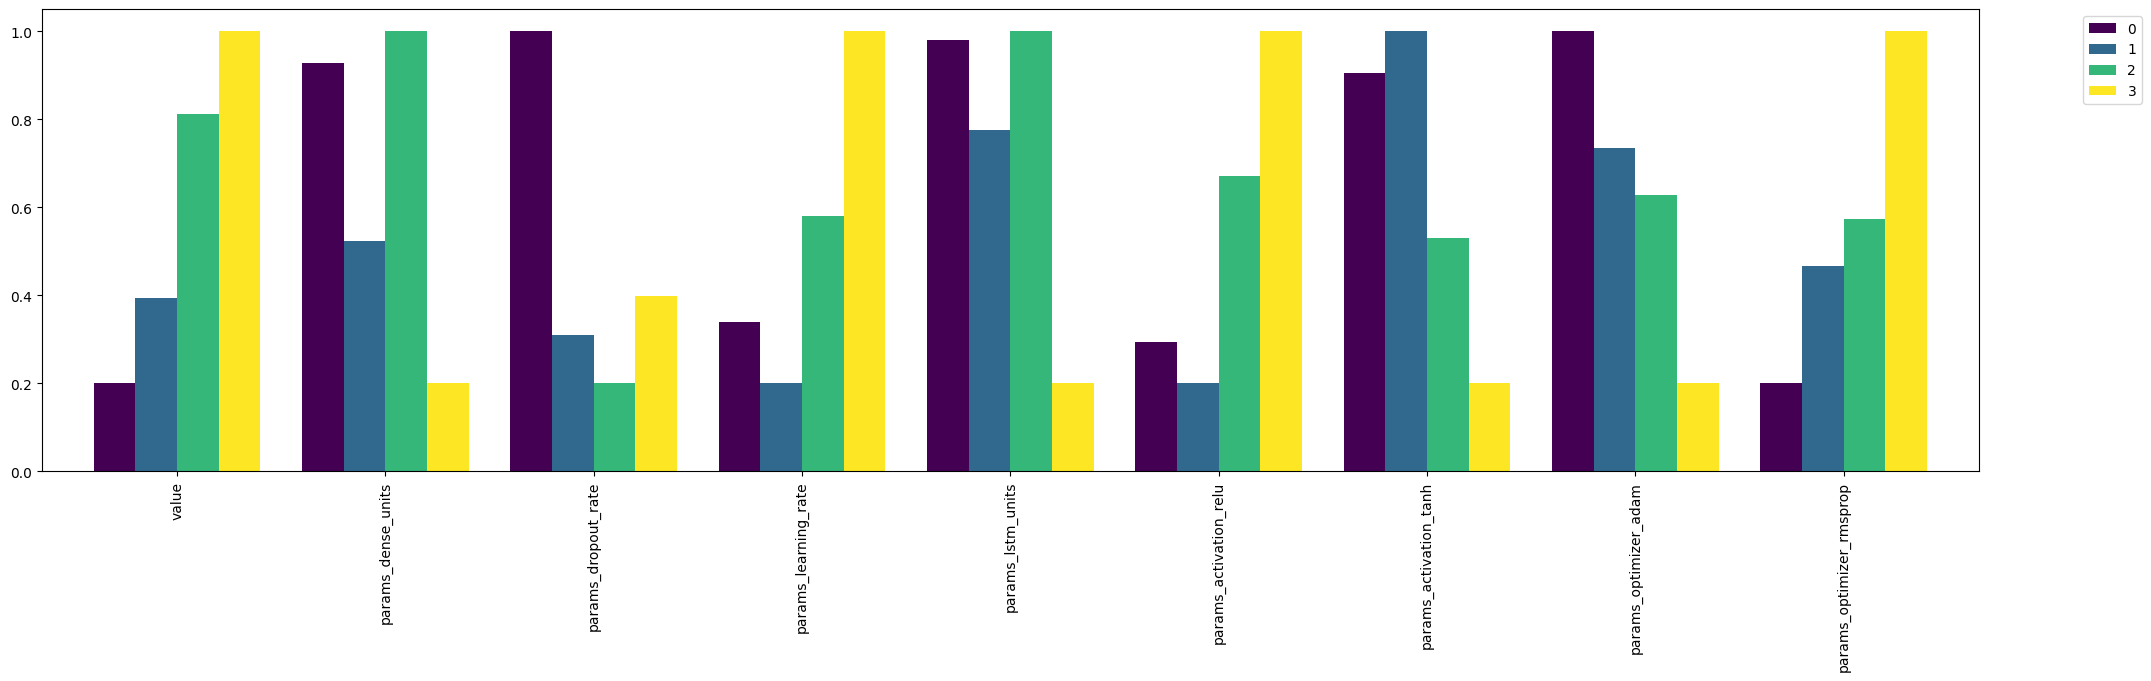

In [117]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
mean_df_scaled = pd.DataFrame(scaler.fit_transform(mean_df), columns=mean_df.columns)
mean_df_scaled = mean_df_scaled * 0.8 + 0.2
# Unstack the DataFrame
mean_df_scaled_transposed = mean_df_scaled.transpose()

# Plot the transposed data as a grouped bar chart
mean_df_scaled_transposed.plot.bar(width=.8, colormap='viridis', figsize=(25, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [73]:
import optuna.visualization as vis

vis.plot_optimization_history(study)

In [72]:
vis.plot_param_importances(study)

### Best optuna

In [69]:
print(study.best_trial.params)

{'lstm_units': 45, 'dense_units': 56, 'dropout_rate': 0.5592946939650149, 'learning_rate': 4.34697201010499e-05, 'activation': 'tanh', 'optimizer': 'rmsprop'}


In [74]:
model_ft_best = Sequential()

# Ajouter les couches
model_ft_best.add(embedding_layer)
model_ft_best.add(LSTM(45))
model_ft_best.add(Dropout(0.56))
model_ft_best.add(Dense(56, activation='tanh', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_ft_best.add(Dropout(0.56))
model_ft_best.add(BatchNormalization())
model_ft_best.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_ft_best.compile(optimizer=RMSprop(learning_rate=4.3e-05), loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
# Entrainer le modèle

# Création du callback
model_save_path_ft_best = "./data/model_best_weights_ft_best.keras"
checkpoint = ModelCheckpoint(model_save_path_ft_best, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_ft_best = model_ft_best.fit(
    X_train_ft, 
    y_train, 
    validation_data=(X_val_ft, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


2987/2987 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.6275 - loss: 3.6799 - val_accuracy: 0.7630 - val_loss: 2.0546
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.8728 - loss: 1.4831 - val_accuracy: 0.7631 - val_loss: 1.0433
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.8954 - loss: 0.6164 - val_accuracy: 0.7622 - val_loss: 0.7346
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9099 - loss: 0.3411 - val_accuracy: 0.7603 - val_loss: 0.6472
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9133 - loss: 0.2726 - val_accuracy: 0.7619 - val_loss: 0.6588
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9197 - loss: 0.2461 - val_accuracy: 0.7631 - val_loss: 0.6633
Epoch 7/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9238 - loss: 0.2343 - val_accuracy: 0.7607 - val_loss: 0.6591
Epoch 8/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9245 - loss: 0.22

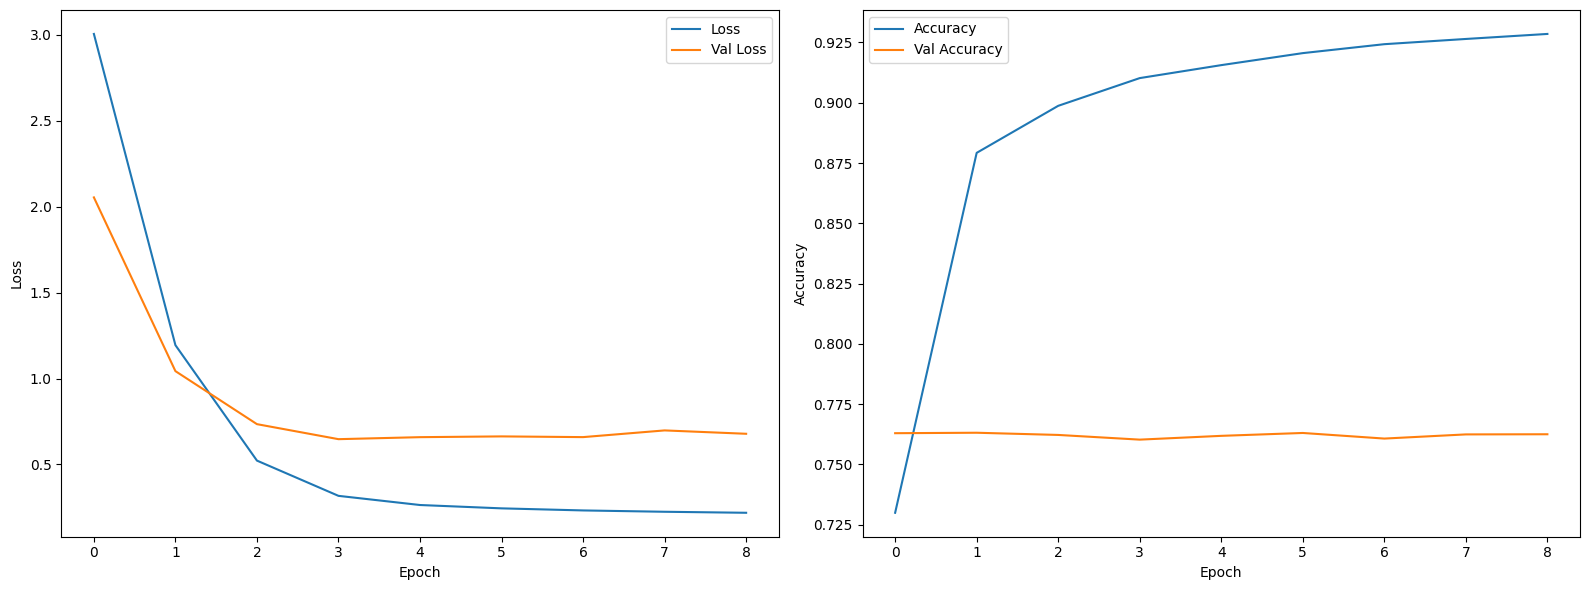

In [77]:
visualize_history(history_ft_best)

In [78]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_ft_best.evaluate(X_val_ft, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_ft_best.evaluate(X_test_ft, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7625
Validation loss:  0.6786
Test Accuracy       :  0.7647
Test loss:  0.6627


In [80]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_ft_best.load_weights(model_save_path_ft_best)

loss, accuracy = model_ft_best.evaluate(X_val_ft, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_ft_best.evaluate(X_test_ft, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7603
Validation loss:  0.6472
Test Accuracy       :  0.7635
Test loss:  0.6376


In [81]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Keras model with LSTM layer and FastText embedding best optuna"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_ft_best.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_ft, model_ft_best.predict(X_train_ft))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_ft_best,
        artifact_path="Keras_FastText_lstm_best",
        signature=signature,
        registered_model_name="Keras_FastText_lstm_best",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


Successfully registered model 'Keras_FastText_lstm_best'.
2024/04/18 20:46:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_FastText_lstm_best, version 1
Created version '1' of model 'Keras_FastText_lstm_best'.
